In [1]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.acband import acband_form_factors, hole_dispersion, K_func1

/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
K = 0.8
# m = 3

sqrt3 = 3.0 ** 0.5
a_M = 1
# lB = ((sqrt3 / (4 * m * np.pi)) ** 0.5) * a_M
lB = ((sqrt3 / (4 * np.pi)) ** 0.5) * a_M

fourier_resolution = 128
G_radius = 16

e1 = np.array([1, 0])
e2 = np.array([0, 1])
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
recip_lattice = lattice.reciprocal()

In [3]:

b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

c1 = (1 / 3) * (b1 - b2)
c2 = (1 / 3) * (b1 - b3)
c3 = (1 / 3) * (b2 - b3)

N = 5

t1 = c1 / (2 * N)
t2 = c2 / (2 * N)

sample_lattice = Lattice2D(np.stack([t1, t2]))
bz = BrillouinZone2D(lattice, sample_lattice)

In [4]:
coords_m_gamma_k_m = np.array(
    [
        [n, n] for n in range(N, 0, -1)
    ] + [
        [0, n] for n in range(0, 2 * N, 1)
    ] + [
        [n, 2 * N - n] for n in range(0, N + 1, 1)
    ] 
)
indices_m_gamma_k_m = np.array(
    [bz.idx_from_coord[tuple(coord.tolist())] for coord in coords_m_gamma_k_m]
)
points_m_gamma_k_m = bz.k_points[indices_m_gamma_k_m]
path_tick_indices = np.array([0, N, 3 * N, 4 * N])
path_tick_labels = [r'$M$', r'$\Gamma$', r'$K$', r'$M$']

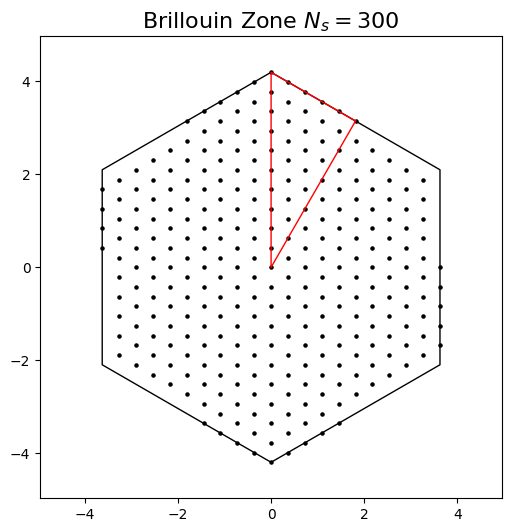

In [5]:
b = (4 * np.pi) / (a_M * sqrt3)
R = b / sqrt3
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

k_points = bz.k_points

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_title(f"Brillouin Zone $N_s={bz.N_s}$", fontsize=16)
ax.set_aspect('equal')
k_x = k_points[:, 0]
k_y = k_points[:, 1]
ax.plot(hexagon_x, hexagon_y, color='k', linewidth=1)
ax.scatter(k_x, k_y, s=5, c='k')
path_x = points_m_gamma_k_m[:, 0]
path_y = points_m_gamma_k_m[:, 1]
ax.plot(path_x, path_y, color='r', linewidth=1)
# for i in range(bz.N_s):
#     x = k_x[i]
#     y = k_y[i]
#     ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')
ax.set_xlim(-36 / b, 36 / b)
ax.set_ylim(-36 / b, 36 / b)
plt.show()

In [6]:
K_func_args = (K, b1, b2, b3)
K_func = partial(K_func1, args=K_func_args)


start = time.time()
G_coords, ac_ff = acband_form_factors(
    bz,
    lB,
    K_func,
    fourier_resolution,
    G_radius=G_radius,
)
end = time.time()
print(f"Form factor computation time: {end - start:.4f} seconds")

start = time.time()
G_coords_fft, ac_ff_fft = acband_form_factors(
    bz,
    lB,
    K_func,
    fourier_resolution,
    G_radius=G_radius,
    fft=True,
)
end = time.time()
print(f"Form factor computation with FFT: {end - start:.4f} seconds")


np.abs(np.max(G_coords - G_coords_fft)), np.max(np.abs(ac_ff - ac_ff_fft))

Form factor computation time: 642.3150 seconds


TypeError: acband_form_factors() got an unexpected keyword argument 'fft'

In [12]:
K_func_args = (K, b1, b2, b3)
K_func = partial(K_func1, args=K_func_args)


start = time.time()
G_coords, ac_ff = acband_form_factors(
    bz,
    lB,
    K_func,
    fourier_resolution,
    G_radius=G_radius,
)
end = time.time()
print(f"Form factor computation time: {end - start:.4f} seconds")

V1 = 1.0
# v1 = 3 * V1 * (a_M ** 4) / (4 * np.pi)
v1 = 3 * V1 * (a_M ** 4) / (8 * np.pi)

def V(q):
    return -v1 * np.linalg.norm(q, axis=-1) ** 2

start = time.time()
dispersion = hole_dispersion(
    bz,
    G_coords,
    ac_ff,
    V,
)
end = time.time()
print(f"Hole dispersion computation time: {end - start:.4f} seconds")

band_width = np.max(dispersion) - np.min(dispersion)

Form factor computation time: 654.1208 seconds
Hole dispersion computation time: 3.6102 seconds


In [13]:
dispersion_along_path = dispersion[indices_m_gamma_k_m]
length_along_path = np.zeros(dispersion_along_path.shape[0])
for i in range(1, length_along_path.shape[0]):
    dk = points_m_gamma_k_m[i] - points_m_gamma_k_m[i - 1]
    length_along_path[i] = length_along_path[i - 1] + np.linalg.norm(dk)

Band width: 3.0187 V1


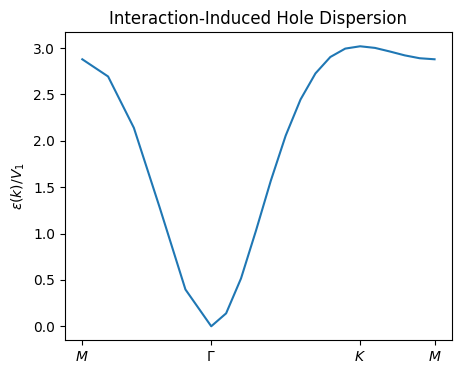

In [14]:
plt.figure(figsize=(5, 4))
plt.plot(length_along_path, dispersion_along_path - np.min(dispersion_along_path))
plt.xticks(length_along_path[path_tick_indices], path_tick_labels)
plt.ylabel("$\\epsilon(k) / V_1$")
plt.title("Interaction-Induced Hole Dispersion")
print(f"Band width: {band_width / V1:.4f} V1")
plt.show()